<a href="https://colab.research.google.com/github/AbhijnaChoodi/MITACS/blob/main/STGSN_Demo%20with%20snp%20edge%20sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/STGSN Demo')

In [2]:
import layers

In [3]:
import loss

In [4]:
import utils

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from layers import GraphNeuralNetwork
from layers import Attention

class STGSN(nn.Module):
    '''
    Class to define DDNE
    '''
    def __init__(self, end_dims, dropout_rate):
        super(STGSN, self).__init__()
        # ====================
        self.enc_dims = end_dims # Layer configuration of encoder
        self.dropout_rate = dropout_rate # Dropout rate
        # ==========
        # Encoder
        self.enc = STGSN_Enc(self.enc_dims, self.dropout_rate)
        self.dec = STGSN_Dec(self.enc_dims[-1], self.dropout_rate)

    def forward(self, sup_list, feat_list, gbl_sup, gbl_feat, num_nodes):
        '''
        Rewrite the forward function
        :param sup_list: list of GNN supports (i.e., normalized adjacency matrices)
        :param feat_list: list of GNN feature inputs (i.e., node attributes)
        :param gbl_sup: global GNN support
        :param gbl_feat: global GNN feature input
        :param num_nodes: number of associated nodes
        :return: prediction result
        '''
        # ====================
        dyn_emb = self.enc(sup_list, feat_list, gbl_sup, gbl_feat, num_nodes)
        adj_est = self.dec(dyn_emb, num_nodes)

        return adj_est

class STGSN_Enc(nn.Module):
    '''
    Class to define the encoder of STGSN
    '''
    def __init__(self, enc_dims, dropout_rate):
        super(STGSN_Enc, self).__init__()
        # ====================
        self.enc_dims = enc_dims # Layer configuration of encoder
        self.dropout_rate = dropout_rate # Dropout rate
        # ==========
        # Structural encoder
        self.num_struc_layers = len(self.enc_dims)-1  # Number of GNN layers
        self.struc_enc = nn.ModuleList()
        for l in range(self.num_struc_layers):
            self.struc_enc.append(
                GraphNeuralNetwork(self.enc_dims[l], self.enc_dims[l+1], dropout_rate=self.dropout_rate))
        # ===========
        # Temporal encoder
        self.att = Attention(self.enc_dims[-1])

    def forward(self, sup_list, feat_list, gbl_sup, gbl_feat, num_nodes):
        '''
        Rewrite the forward function
        :param sup_list: list of GNN supports (i.e., normalized adjacency matrices)
        :param feat_list: list of GNN feature inputs (i.e., node attributes)
        :param gbl_sup: global GNN support
        :param gbl_feat: global GNN feature input
        :param num_nodes: number of associated nodes
        :return: dynamic node embedding
        '''
        # ====================
        win_size = len(sup_list) # Window size, i.e., #historical snapshots
        # ====================
        # Structural encoder
        ind_input_list = feat_list # List of attribute inputs w.r.t. historical snapshots
        gbl_input = gbl_feat
        ind_output_list = None # List of embedding outputs w.r.t. historical snapshots
        gbl_output = None
        for l in range(self.num_struc_layers):
            gbl_output = self.struc_enc[l](gbl_input, gbl_sup)
            gbl_input = gbl_output
            # ==========
            ind_output_list = []
            for i in range(win_size):
                ind_input = ind_input_list[i]
                ind_sup = sup_list[i]
                ind_output = self.struc_enc[l](ind_input, ind_sup)
                ind_output_list.append(ind_output)
            ind_input_list = ind_output_list
        gbl_emb = gbl_output
        ind_emb_list = ind_output_list
        # ==========
        # Temporal encoder
        agg_emb = self.att(ind_emb_list, gbl_emb, num_nodes)
        dyn_emb = torch.cat((agg_emb, gbl_emb), dim=1) # Dynamic node embedding

        return dyn_emb

class STGSN_Dec(nn.Module):
    '''
    Class to define the decoder of STGSN
    '''
    def __init__(self, emb_dim, dropout_rate):
        super(STGSN_Dec, self).__init__()
        # ====================
        self.emb_dim = emb_dim # Dimensionality of dynamic embedding
        self.dropout_rate = dropout_rate # Dropout rate
        # ==========
        self.dec = nn.Linear(4*self.emb_dim, 1)

    def forward(self, dyn_emb, num_nodes):
        '''
        Rewrite the forward function
        :param dyn_emb: dynamic embedding given by encoder
        :param num_nodes: number of associated nodes
        :return: prediction result
        '''
        # ====================
        adj_est = None
        for i in range(num_nodes):
            cur_emb = dyn_emb[i, :]
            cur_emb = torch.reshape(cur_emb, (1, self.emb_dim*2))
            cur_emb = cur_emb.repeat(num_nodes, 1)
            cat_emb = torch.cat((cur_emb, dyn_emb), dim=1)
            col_est = torch.sigmoid(self.dec(cat_emb))
            if i == 0:
                adj_est = col_est
            else:
                adj_est = torch.cat((adj_est, col_est), dim=1)

        return adj_est

In [11]:
# Demonstration of STGSN
import utils
import torch
import torch.optim as optim
#from modules import *
from loss import *
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ====================
data_name = 'Mesh-1'
num_nodes = 506 # Number of nodes (Level-1 w/ fixed node set)
num_snaps = 13 # Number of snapshots
max_thres = 1 # Threshold for maximum edge weight
feat_dim = 10 # Dimensionality of feature input
enc_dims = [feat_dim, 32, 32, 32] # Layer configuration of encoder
emb_dim = enc_dims[-1] # Dimensionality of dynamic embedding
win_size = 10 # Window size of historical snapshots
theta = 0.1 # Hyper-parameter for collapsed graph

# ====================
edge_seq = np.load('/content/drive/MyDrive/STGSN Demo/data/adjacency matrix.npy', allow_pickle=True)

max_value = np.max(edge_seq)
edge_seq = edge_seq / max_value

feat = np.load('/content/drive/MyDrive/STGSN Demo/data/feat demo.npy', allow_pickle=True)
feat_tnr = torch.FloatTensor(feat).to(device)
feat_list = []
for i in range(win_size):
    feat_list.append(feat_tnr)

# ====================
dropout_rate = 0.2 # Dropout rate
epsilon = 1e-2 # Threshold of zero-refining
batch_size = 1 # Batch size
num_epochs = 10 # Number of training epochs
num_val_snaps = 2 # Number of validation snapshots
num_test_snaps = 5 # Number of test snapshots
num_train_snaps = num_snaps-num_test_snaps-num_val_snaps # Number of training snapshots

# ====================
# Define the model
model = STGSN(enc_dims, dropout_rate).to(device)
# ==========
# Define the optimizer
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# ====================
for epoch in range(num_epochs):
    # ====================
    # Pre-train the model
    model.train()
    num_batch = int(np.ceil(num_train_snaps/batch_size))  # Number of batch
    total_loss = 0.0
    for b in range(num_batch):
        start_idx = b*batch_size
        end_idx = (b+1)*batch_size
        if end_idx>num_train_snaps:
            end_idx = num_train_snaps
        # ====================
        # Training for current batch
        batch_loss = 0.0
        for tau in range(start_idx, end_idx):
            # ==========
            sup_list = []  # List of GNN support (tensor)
            col_net = np.zeros((num_nodes, num_nodes))
            coef_sum = 0.0
            for t in range(tau-win_size, tau):
                # ==========
                edges = edge_seq[t]
                adj = get_adj_wei(edges, num_nodes, max_thres)
                adj_norm = adj/max_thres
                sup = get_gnn_sup_d(adj_norm)
                sup_sp = sp.sparse.coo_matrix(sup)
                sup_sp = sparse_to_tuple(sup_sp)
                idxs = torch.LongTensor(sup_sp[0].astype(float)).to(device)
                vals = torch.FloatTensor(sup_sp[1]).to(device)
                sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, sup_sp[2]).float().to(device)
                sup_list.append(sup_tnr)
                # ==========
                coef = (1-theta)**(tau-t)
                col_net += coef*adj_norm
                coef_sum += coef
            # ==========
            col_net /= coef_sum
            col_sup = get_gnn_sup_d(col_net)
            col_sup_sp = sp.sparse.coo_matrix(col_sup)
            col_sup_sp = sparse_to_tuple(col_sup_sp)
            idxs = torch.LongTensor(col_sup_sp[0].astype(float)).to(device)
            vals = torch.FloatTensor(col_sup_sp[1]).to(device)
            col_sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, col_sup_sp[2]).float().to(device)
            # ==========
            edges = edge_seq[tau]
            gnd = get_adj_wei(edges, num_nodes, max_thres) # Training ground-truth
            gnd_norm = gnd/max_thres # Normalize the edge weights (in ground-truth) to [0, 1]
            gnd_tnr = torch.FloatTensor(gnd_norm).to(device)
            # ==========
            adj_est = model(sup_list, feat_list, col_sup_tnr, feat_tnr, num_nodes)
            loss_ = get_STGSN_loss_wei(adj_est, gnd_tnr)
            batch_loss = batch_loss + loss_
        # ===========
        # Update model parameter according to batch loss
        opt.zero_grad()
        batch_loss.backward()
        opt.step()
        total_loss = total_loss + batch_loss
    print('Epoch %d Total Loss %f' % (epoch, total_loss))

    # ====================
    # Validate the model
    model.eval()
    # ==========
    RMSE_list = []
    MAE_list = []
    for tau in range(num_snaps-num_test_snaps-num_val_snaps, num_snaps-num_test_snaps):
        # ====================
        sup_list = [] # List of GNN support (tensor)
        col_net = np.zeros((num_nodes, num_nodes))
        coef_sum = 0.0
        for t in range(tau-win_size, tau):
            # ==========
            edges = edge_seq[t]
            adj = get_adj_wei(edges, num_nodes, max_thres)
            adj_norm = adj / max_thres
            sup = get_gnn_sup_d(adj_norm)
            sup_sp = sp.sparse.coo_matrix(sup)
            sup_sp = sparse_to_tuple(sup_sp)
            idxs = torch.LongTensor(sup_sp[0].astype(float)).to(device)
            vals = torch.FloatTensor(sup_sp[1]).to(device)
            sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, sup_sp[2]).float().to(device)
            sup_list.append(sup_tnr)
            # ==========
            coef = (1-theta)**(tau-t)
            col_net += coef*adj_norm
            coef_sum += coef
        # ==========
        col_net /= coef_sum
        col_sup = get_gnn_sup_d(col_net)
        col_sup_sp = sp.sparse.coo_matrix(col_sup)
        col_sup_sp = sparse_to_tuple(col_sup_sp)
        idxs = torch.LongTensor(col_sup_sp[0].astype(float)).to(device)
        vals = torch.FloatTensor(col_sup_sp[1]).to(device)
        col_sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, col_sup_sp[2]).float().to(device)
        # ==========
        # Get the prediction result
        adj_est = model(sup_list, feat_list, col_sup_tnr, feat_tnr, num_nodes)
        if torch.cuda.is_available():
            adj_est = adj_est.cpu().data.numpy()
        else:
            adj_est = adj_est.data.numpy()
        adj_est *= max_thres  # Rescale the edge weights to the original value range
        # ==========
        # Refine the prediction result
        adj_est = (adj_est+adj_est.T)/2
        for r in range(num_nodes):
            adj_est[r, r] = 0
        for r in range(num_nodes):
            for c in range(num_nodes):
                if adj_est[r, c] <= epsilon:
                    adj_est[r, c] = 0

        # ====================
        # Get the ground-truth
        edges = edge_seq[tau]
        gnd = get_adj_wei(edges, num_nodes, max_thres)
        # ====================
        # Evaluate the prediction result
        RMSE = get_RMSE(adj_est, gnd, num_nodes)
        MAE = get_MAE(adj_est, gnd, num_nodes)
        # ==========
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)

    # ====================
    RMSE_mean = np.mean(RMSE_list)
    RMSE_std = np.std(RMSE_list, ddof=1)
    MAE_mean = np.mean(MAE_list)
    MAE_std = np.std(MAE_list, ddof=1)
    print('Val #%d RMSE %f %f MAE %f %f' % (epoch, RMSE_mean, RMSE_std, MAE_mean, MAE_std))

    # ====================
    # Test the model
    model.eval()
    # ==========
    RMSE_list = []
    MAE_list = []
    for tau in range(num_snaps-num_test_snaps, num_snaps):
        # ====================
        sup_list = []  # List of GNN support (tensor)
        col_net = np.zeros((num_nodes, num_nodes))
        coef_sum = 0.0
        for t in range(tau-win_size, tau):
            # ==========
            edges = edge_seq[t]
            adj = get_adj_wei(edges, num_nodes, max_thres)
            adj_norm = adj/max_thres
            sup = get_gnn_sup_d(adj_norm)
            sup_sp = sp.sparse.coo_matrix(sup)
            sup_sp = sparse_to_tuple(sup_sp)
            idxs = torch.LongTensor(sup_sp[0].astype(float)).to(device)
            vals = torch.FloatTensor(sup_sp[1]).to(device)
            sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, sup_sp[2]).float().to(device)
            sup_list.append(sup_tnr)
            # ==========
            coef = (1-theta)**(tau-t)
            col_net += coef*adj_norm
            coef_sum += coef
        # ==========
        col_net /= coef_sum
        col_sup = get_gnn_sup_d(col_net)
        col_sup_sp = sp.sparse.coo_matrix(col_sup)
        col_sup_sp = sparse_to_tuple(col_sup_sp)
        idxs = torch.LongTensor(col_sup_sp[0].astype(float)).to(device)
        vals = torch.FloatTensor(col_sup_sp[1]).to(device)
        col_sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, col_sup_sp[2]).float().to(device)
        # ==========
        # Get the prediction result
        adj_est = model(sup_list, feat_list, col_sup_tnr, feat_tnr, num_nodes)
        if torch.cuda.is_available():
            adj_est = adj_est.cpu().data.numpy()
        else:
            adj_est = adj_est.data.numpy()
        adj_est *= max_thres  # Rescale the edge weights to the original value range
        # ==========
        # Refine the prediction result
        adj_est = (adj_est+adj_est.T)/2
        for r in range(num_nodes):
            adj_est[r, r] = 0
        for r in range(num_nodes):
            for c in range(num_nodes):
                if adj_est[r, c] <= epsilon:
                    adj_est[r, c] = 0

        # ====================
        # Get the ground-truth
        edges = edge_seq[tau]
        gnd = get_adj_wei(edges, num_nodes, max_thres)
        # ====================
        # Evaluate the prediction result
        RMSE = get_RMSE(adj_est, gnd, num_nodes)
        MAE = get_MAE(adj_est, gnd, num_nodes)
        # ==========
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)

    # ====================
    RMSE_mean = np.mean(RMSE_list)
    RMSE_std = np.std(RMSE_list, ddof=1)
    MAE_mean = np.mean(MAE_list)
    MAE_std = np.std(MAE_list, ddof=1)
    print('Test #%d RMSE %f %f MAE %f %f' % (epoch, RMSE_mean, RMSE_std, MAE_mean, MAE_std))
    print()

Epoch 0 Total Loss 337520.000000
Val #0 RMSE 0.465268 0.000000 MAE 0.464726 0.000000
Test #0 RMSE 0.465268 0.000000 MAE 0.464726 0.000000

Epoch 1 Total Loss 325596.312500
Val #1 RMSE 0.455608 0.000000 MAE 0.455064 0.000000
Test #1 RMSE 0.455608 0.000000 MAE 0.455064 0.000000

Epoch 2 Total Loss 313837.937500
Val #2 RMSE 0.445692 0.000000 MAE 0.445148 0.000000
Test #2 RMSE 0.445692 0.000000 MAE 0.445148 0.000000

Epoch 3 Total Loss 303997.781250
Val #3 RMSE 0.435636 0.000000 MAE 0.435098 0.000000
Test #3 RMSE 0.435636 0.000000 MAE 0.435098 0.000000

Epoch 4 Total Loss 293611.250000
Val #4 RMSE 0.425639 0.000000 MAE 0.425110 0.000000
Test #4 RMSE 0.425639 0.000000 MAE 0.425110 0.000000

Epoch 5 Total Loss 282151.937500
Val #5 RMSE 0.415772 0.000000 MAE 0.415258 0.000000
Test #5 RMSE 0.415772 0.000000 MAE 0.415258 0.000000

Epoch 6 Total Loss 272243.312500
Val #6 RMSE 0.406188 0.000000 MAE 0.405694 0.000000
Test #6 RMSE 0.406188 0.000000 MAE 0.405694 0.000000

Epoch 7 Total Loss 261968.3

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the dynamic graph data
edge_seq = np.load('/content/drive/MyDrive/STGSN Demo/data/Mesh-1_edge_seq.npy', allow_pickle=True)

# Create an empty graph
G = nx.Graph()

# Visualize the dynamic graph
for t, edges in enumerate(edge_seq):
    # Clear the previous plot
    plt.clf()

    # Add edges from the current time snapshot
    for edge in edges:
        u, v, weight = edge
        G.add_edge(u, v, weight=weight)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title(f"Dynamic Graph at Time {t}")
    plt.pause(1)  # Pause for 1 second before moving to the next time snapshot

# Display the final graph
plt.show()


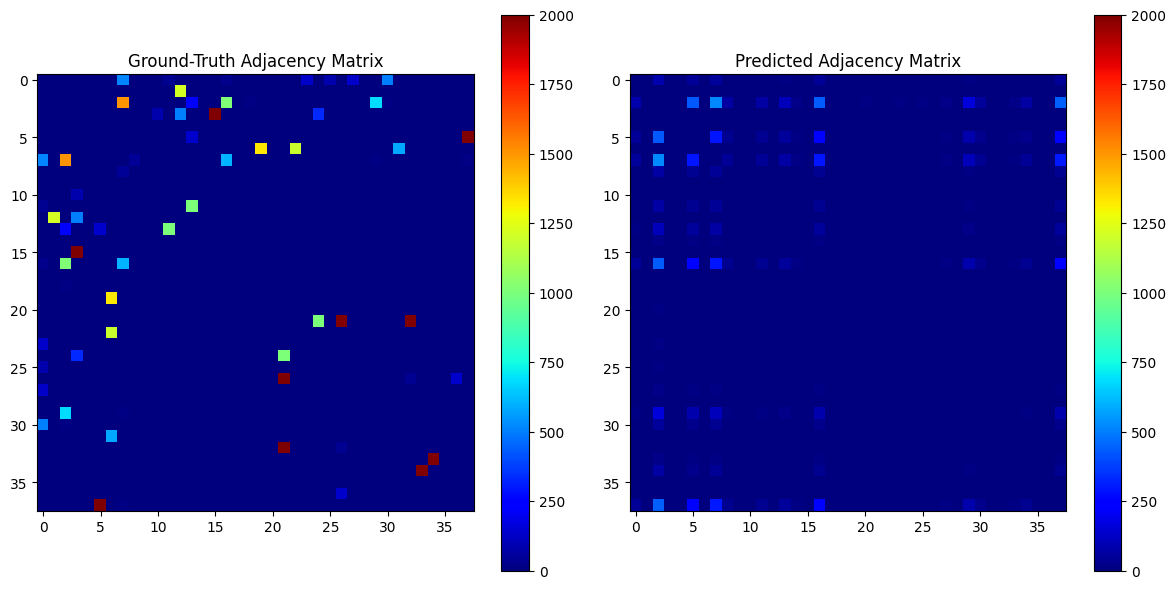

In [ ]:
import matplotlib.pyplot as plt

# ====================
# Test the model
model.eval()
tau = num_snaps - 1  # Final snapshot in the test data

# ====================
sup_list = []  # List of GNN support (tensor)
col_net = np.zeros((num_nodes, num_nodes))
coef_sum = 0.0
for t in range(tau - win_size, tau):
    # ==========
    edges = edge_seq[t]
    adj = get_adj_wei(edges, num_nodes, max_thres)
    adj_norm = adj / max_thres
    sup = get_gnn_sup_d(adj_norm)
    sup_sp = sp.sparse.coo_matrix(sup)
    sup_sp = sparse_to_tuple(sup_sp)
    idxs = torch.LongTensor(sup_sp[0].astype(float)).to(device)
    vals = torch.FloatTensor(sup_sp[1]).to(device)
    sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, sup_sp[2]).float().to(device)
    sup_list.append(sup_tnr)
    # ==========
    coef = (1 - theta) ** (tau - t)
    col_net += coef * adj_norm
    coef_sum += coef
# ==========
col_net /= coef_sum
col_sup = get_gnn_sup_d(col_net)
col_sup_sp = sp.sparse.coo_matrix(col_sup)
col_sup_sp = sparse_to_tuple(col_sup_sp)
idxs = torch.LongTensor(col_sup_sp[0].astype(float)).to(device)
vals = torch.FloatTensor(col_sup_sp[1]).to(device)
col_sup_tnr = torch.sparse.FloatTensor(idxs.t(), vals, col_sup_sp[2]).float().to(device)
# ==========
# Get the prediction result
adj_est = model(sup_list, feat_list, col_sup_tnr, feat_tnr, num_nodes)
if torch.cuda.is_available():
    adj_est = adj_est.cpu().data.numpy()
else:
    adj_est = adj_est.data.numpy()
adj_est *= max_thres  # Rescale the edge weights to the original value range
# ==========
# Refine the prediction result
adj_est = (adj_est + adj_est.T) / 2
for r in range(num_nodes):
    adj_est[r, r] = 0
for r in range(num_nodes):
    for c in range(num_nodes):
        if adj_est[r, c] <= epsilon:
            adj_est[r, c] = 0

# ====================
# Get the ground-truth
edges = edge_seq[tau]
gnd = get_adj_wei(edges, num_nodes, max_thres)

# ====================
# Plot the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gnd, cmap='jet', vmin=0, vmax=max_thres)
plt.colorbar()
plt.title('Ground-Truth Adjacency Matrix')

plt.subplot(1, 2, 2)
plt.imshow(adj_est, cmap='jet', vmin=0, vmax=max_thres)
plt.colorbar()
plt.title('Predicted Adjacency Matrix')

plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the dynamic graph data and prediction results
edge_seq = np.load('/content/drive/MyDrive/STGSN Demo/data/Mesh-1_edge_seq.npy', allow_pickle=True)
pred_results = []  # Add your predicted adjacency matrices here

# Create an empty graph
G = nx.Graph()

# Determine the number of snapshots to visualize
num_snapshots = min(10, len(edge_seq))

# Visualize the predicted graphs for the last 'num_snapshots' snapshots
for t in range(max(0, len(edge_seq) - num_snapshots), len(edge_seq)):
    # Clear the previous plot
    plt.clf()

    # Add edges from the ground truth if available
    if len(edge_seq[t]) > 0:
        for edge in edge_seq[t]:
            u, v, weight = edge
            G.add_edge(u, v, weight=weight, color='blue')

    # Add edges from the prediction if available
    if len(pred_results) > t:
        pred_adj = pred_results[t]  # Get the predicted adjacency matrix for the current snapshot
        for u in range(pred_adj.shape[0]):
            for v in range(u + 1, pred_adj.shape[1]):
                if pred_adj[u, v] > 0:
                    G.add_edge(u, v, weight=pred_adj[u, v], color='red')

    # Draw the graph with different edge colors for ground truth and prediction
    pos = nx.spring_layout(G)
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors)
    plt.title(f"Predicted Graph at Time {t}")
    plt.pause(1)  # Pause for 1 second before moving to the next snapshot

    # Clear the graph for the next iteration
    G.clear()

# Display the final graph
plt.show()
